# Введение

In [98]:
#!pip install lightgbm

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgbm

import warnings 
warnings.filterwarnings('ignore')

## Используемые функции

In [100]:
def plot_feature_hue_var(df, feature1, target_var):
    
    #df - датасет, в котором оцениваем признаки
    #feature1 - какой признак рассматриваем в разрезе целевой переменной target_var
    #target_var - целевая переменная
    
    plt.figure(figsize=(10, 8))

    sns.countplot(x=feature1, hue=target_var, data=df)
    plt.title(f'{feature1} grouped by {target_var}')
    plt.legend(title=target_var, loc='upper right')

    plt.show()

In [101]:
def my_chi2_contingency(data, feature, feature_var1, feature_var2, target_var, id_var):
    
    #data - датасет
    #feature - название признака
    #feature_var1, feature_var2 - два значения признака feature, которые оцениваем по критерию Хи-квадрат
    #target_var - целевая переменная вразрезе которой оцениваем наш признак
    #id_var - название столбца для ID
    
    var_and_target = data.loc[data[feature].isin([feature_var1, feature_var2]), [id_var, feature, target_var]].sample(100)
    
    table = var_and_target.pivot_table(values=id_var, index = feature, columns=target_var, aggfunc='count')
       
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(f'p-value = {p}')
    print()
    if p > 0.05:
        print(f'Значение p-value для признаков {feature_var1} и {feature_var2} получилось больше 0,05, '
              f'соответственно нет повода для отвержения нулевой гипотезы, а значит признаки одинаково '
              f'влияют на целевую переменную. Объединим их в один признак.')
    else:
        print(f'Значение p-value для признаков {feature_var1} и {feature_var2} получилось меньше 0,05, '
              f'соответственно принимаем альтернативную гипотезу.')
              

In [102]:
def correliation_features(data, list_of_features, target_feature):
    
    #data - датасет, в котором оцениваем признаки
    #list_of_features - список признаков среди которых проводим корреляцию
    #target_feature - целевой признак, для которого оцениваем корреляцию с другими признаками
 
    corr_with_target_feature = data[list_of_features[:-1] + [target_feature]].corr().iloc[:-1,-1].sort_values(ascending = False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x = corr_with_target_feature.values, y = corr_with_target_feature.index)

    plt.title(f'Correlation with {target_feature}')
    plt.show();

In [103]:
def my_accuracy_score(train_true, train_pred, test_true, test_pred):
    
    #train_true - верные ответы на тренировочном датасете
    #train_pred - предсказанные ответы на тренировочном датасете
    #test_true - верные ответы на тестовом датасете
    #test_pred - предсказанные ответы на тестовом датасете
    
    acc_sc_train = accuracy_score(train_true, train_pred)
    acc_sc_test = accuracy_score(test_true, test_pred)
    
    print(f'Метрика accuracy на тренировочном датасете: {acc_sc_train}')
    print(f'Метрика accuracy на тестовом датасете: {acc_sc_test}')

## Датасет

In [104]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
gender_submission_exmple = 'gender_submission.csv'

In [105]:
df_train = pd.read_csv(TRAIN_PATH)# index_col = 'PassengerId')
df_test = pd.read_csv(TEST_PATH) #index_col = 'PassengerId')
df_example = pd.read_csv(gender_submission_exmple)

In [106]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [107]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [108]:
df_example.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [109]:
TARGET_VAR = 'Survived'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_VAR).tolist()

# Анализ данных

## Корреляция целевой переменном с базовыми признаками

In [110]:
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

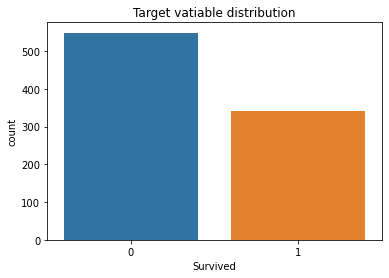

In [111]:
sns.countplot(x = 'Survived', data = df_train)
plt.title('Target vatiable distribution')
plt.show()

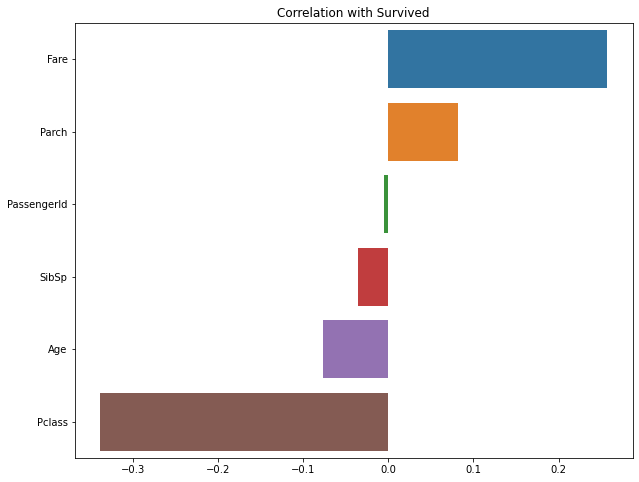

In [112]:
correliation_features(df_train, BASE_FEATURE_NAMES, TARGET_VAR)

## Обзор количественных признаков

In [113]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [114]:
feature_num_names = df_train.drop('Survived', axis = 1).select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_num_names

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

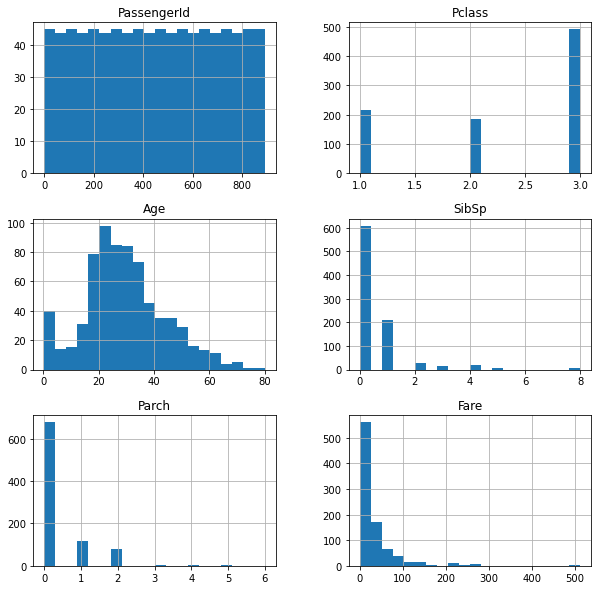

In [115]:
df_train[feature_num_names].hist(figsize=(10,10), bins = 20);

## Обзор категориальных переменных

### Обзор переменной Embarked

In [116]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

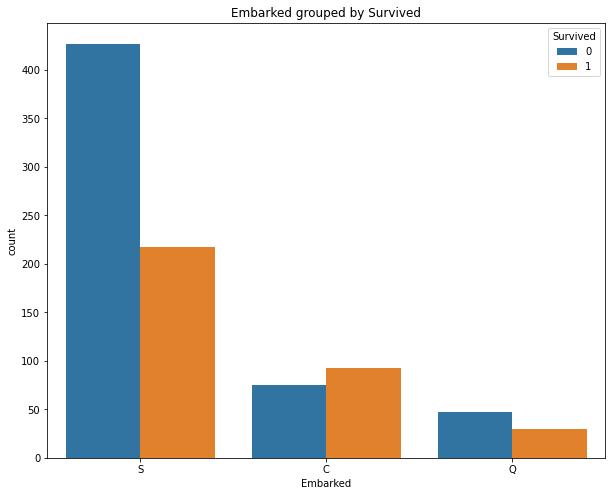

In [117]:
plot_feature_hue_var(df_train, 'Embarked', TARGET_VAR)

In [118]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [119]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


В тренировочном датасете есть два пропуска, которые заполним наиболее часто встречающимся значением S

In [120]:
df_train['Embarked'].fillna('S', inplace = True)

In [121]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Создание признака EmbarkedPerPclass

Посмотрим расперделение каждого класса по признаку Embarked

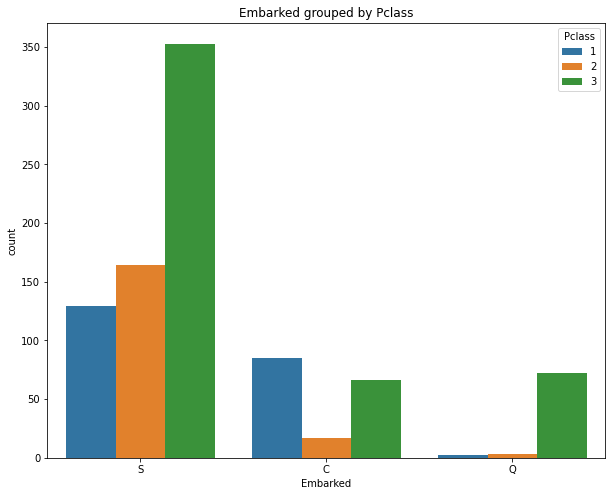

In [122]:
plot_feature_hue_var(df_train, 'Embarked', 'Pclass')

Cоздадим новый признак, сочетающий признаки Embarked и Pclass

In [123]:
df_train['EmbarkedPerPclass'] = df_train['Embarked'] + df_train.astype({'Pclass': 'str'})['Pclass']
df_test['EmbarkedPerPclass'] = df_test['Embarked'] + df_test.astype({'Pclass': 'str'})['Pclass']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedPerPclass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,S3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,S3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,S1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,S3


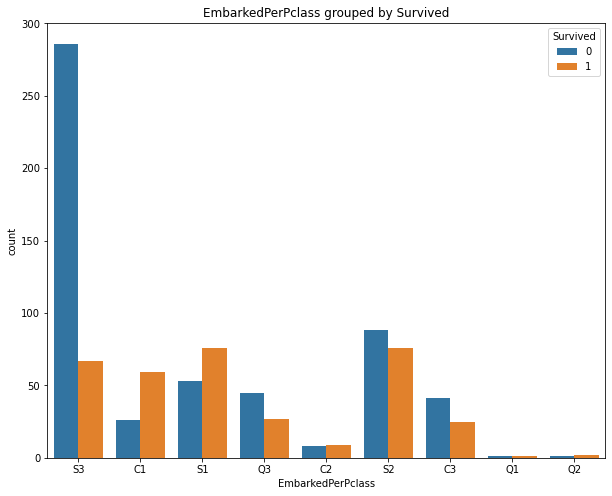

In [124]:
plot_feature_hue_var(df_train, 'EmbarkedPerPclass', TARGET_VAR)

Очевидно, что значения признаков Q1 и Q2 можно объединить в один Q1_2.

In [125]:
df_train.replace(to_replace = 'Q1', value = 'Q1_2', inplace = True)
df_train.replace(to_replace = 'Q2', value = 'Q1_2', inplace = True)

df_test.replace(to_replace = 'Q1', value = 'Q1_2', inplace = True)
df_test.replace(to_replace = 'Q2', value = 'Q1_2', inplace = True)

In [126]:
df_train.loc[(df_train['EmbarkedPerPclass'] == 'Q1_2'), ['EmbarkedPerPclass']]

,EmbarkedPerPclass
245,Q1_2
303,Q1_2
322,Q1_2
412,Q1_2
626,Q1_2


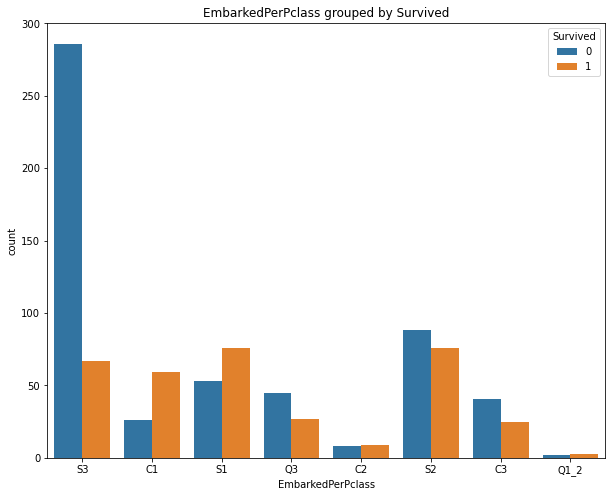

In [127]:
plot_feature_hue_var(df_train, 'EmbarkedPerPclass', TARGET_VAR)

Проверим гипотезу о том согласованы ли частоты признаков Q3 и C3, а также C1 и S1.

Гипотеза

1. Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
2. Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
3. Критерий: Хи-квадрат Пирсона
4. Уровень значимости 𝛼 : 0.05
5. Критическая область: двухсторонняя

In [128]:
my_chi2_contingency(df_train, feature='EmbarkedPerPclass', feature_var1='Q3', 
                    feature_var2='C3', target_var='Survived', id_var='PassengerId')

p-value = 0.7437736057682316

Значение p-value для признаков Q3 и C3 получилось больше 0,05, соответственно нет повода для отвержения нулевой гипотезы, а значит признаки одинаково влияют на целевую переменную. Объединим их в один признак.


In [129]:
df_train.replace(to_replace = 'Q3', value = 'Q-C3', inplace = True)
df_train.replace(to_replace = 'C3', value = 'Q-C3', inplace = True)

df_test.replace(to_replace = 'Q3', value = 'Q-C3', inplace = True)
df_test.replace(to_replace = 'C3', value = 'Q-C3', inplace = True)

In [130]:
my_chi2_contingency(df_train, feature='EmbarkedPerPclass', feature_var1='C1', 
                    feature_var2='S1', target_var='Survived', id_var='PassengerId')

p-value = 0.7498205359234522

Значение p-value для признаков C1 и S1 получилось больше 0,05, соответственно нет повода для отвержения нулевой гипотезы, а значит признаки одинаково влияют на целевую переменную. Объединим их в один признак.


In [131]:
df_train.replace(to_replace = 'C1', value = 'C-S1', inplace = True)
df_train.replace(to_replace = 'S1', value = 'C-S1', inplace = True)

df_test.replace(to_replace = 'C1', value = 'C-S1', inplace = True)
df_test.replace(to_replace = 'S1', value = 'C-S1', inplace = True)

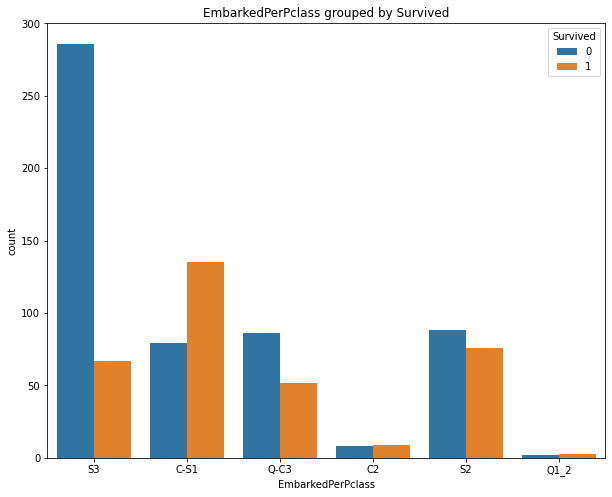

In [132]:
plot_feature_hue_var(df_train, 'EmbarkedPerPclass', TARGET_VAR)

#### Создание признака EmbarkedPerSex

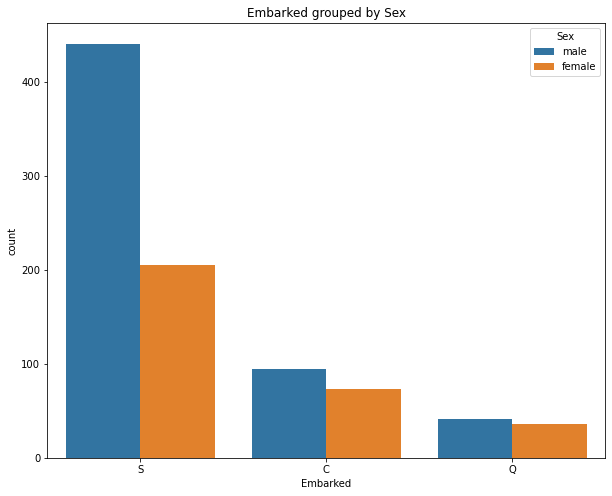

In [133]:
plot_feature_hue_var(df_train, 'Embarked', 'Sex')

In [134]:
df_train['EmbarkedPerSex'] = df_train['Embarked'] + '_' + df_train['Sex']
df_test['EmbarkedPerSex'] = df_test['Embarked'] +'_' + df_test['Sex']
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedPerPclass,EmbarkedPerSex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,S3,S_male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C-S1,C_female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,S3,S_female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C-S1,S_female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,S3,S_male


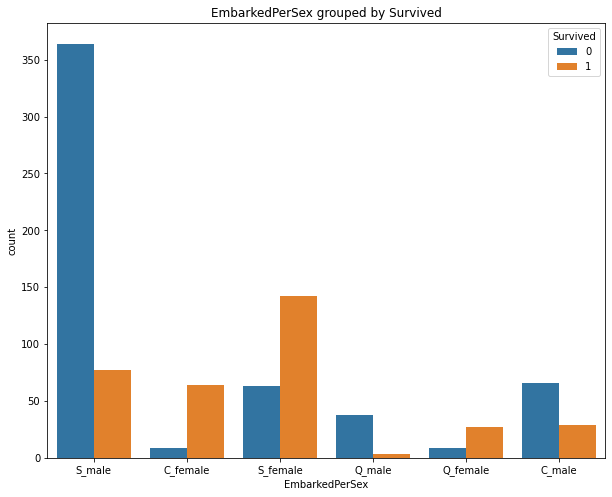

In [135]:
plot_feature_hue_var(df_train, 'EmbarkedPerSex', TARGET_VAR)

#### Преобразование новых признаков из категориальных в количественные

Для преобразования признаков из категориальных в количественные воспользуемся моделью LabelEncoder библиотеки sklearn

In [136]:
le = LabelEncoder()
le.fit(df_train.Embarked)
df_train['Embarked'] = le.transform(df_train.Embarked)
df_test['Embarked'] = le.transform(df_test.Embarked)

In [137]:
le.fit(df_train.EmbarkedPerPclass)
df_train['EmbarkedPerPclass'] = le.transform(df_train.EmbarkedPerPclass)
df_test['EmbarkedPerPclass'] = le.transform(df_test.EmbarkedPerPclass)

In [138]:
le.fit(df_train.EmbarkedPerSex)
df_train['EmbarkedPerSex'] = le.transform(df_train.EmbarkedPerSex)
df_test['EmbarkedPerSex'] = le.transform(df_test.EmbarkedPerSex)

In [139]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           891 non-null    int32  
 12  EmbarkedPerPclass  891 non-null    int32  
 13  EmbarkedPerSex     891 non-null    int32  
dtypes: float64(2), int32(3), int64(5), object(4)
memory usage: 87.1+ KB


### Анализ остальных признаков

In [140]:
for cat_colnames in df_train.select_dtypes(include='object').columns:
    print(str(cat_colnames) + '\n\n' + str(df_train[cat_colnames].value_counts()) + '\n' + '*' * 100 + '\n')

Name

Toomey, Miss. Ellen                                    1
Jansson, Mr. Carl Olof                                 1
Dean, Master. Bertram Vere                             1
Jensen, Mr. Svend Lauritz                              1
Moran, Mr. Daniel J                                    1
                                                      ..
Kimball, Mr. Edwin Nelson Jr                           1
Flynn, Mr. James                                       1
Sadlier, Mr. Matthew                                   1
Abbing, Mr. Anthony                                    1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Name: Name, Length: 891, dtype: int64
****************************************************************************************************

Sex

male      577
female    314
Name: Sex, dtype: int64
****************************************************************************************************

Ticket

CA. 2343    7
347082      7
1601        7
CA 2144     6
3101

Очевидно, что признаки Name, Ticket и Cabin никак не влияют на целевую переменную.

In [141]:
df_train.drop(['Name', 'Ticket', 'Cabin'], axis = 1,  inplace=True)
df_test.drop(['Name', 'Ticket', 'Cabin'], axis = 1,  inplace=True)

In [142]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Sex                891 non-null    object 
 4   Age                714 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Fare               891 non-null    float64
 8   Embarked           891 non-null    int32  
 9   EmbarkedPerPclass  891 non-null    int32  
 10  EmbarkedPerSex     891 non-null    int32  
dtypes: float64(2), int32(3), int64(5), object(1)
memory usage: 66.3+ KB


### Анализ признака Sex в разрезе целевой переменной

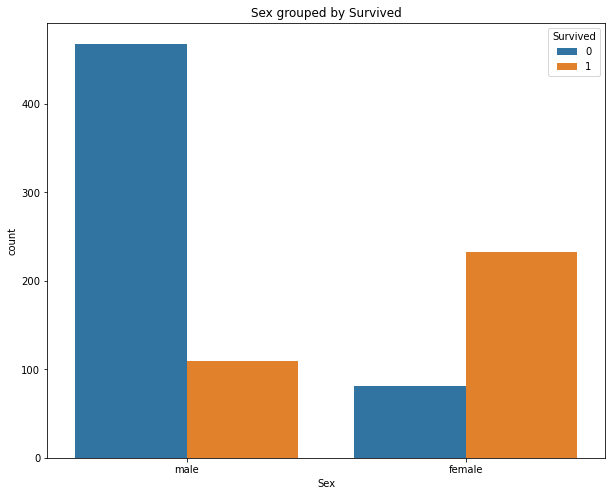

In [143]:
plot_feature_hue_var(df_train, 'Sex', TARGET_VAR)

Проанализируем пассажиров по полу в разрезе Pclass

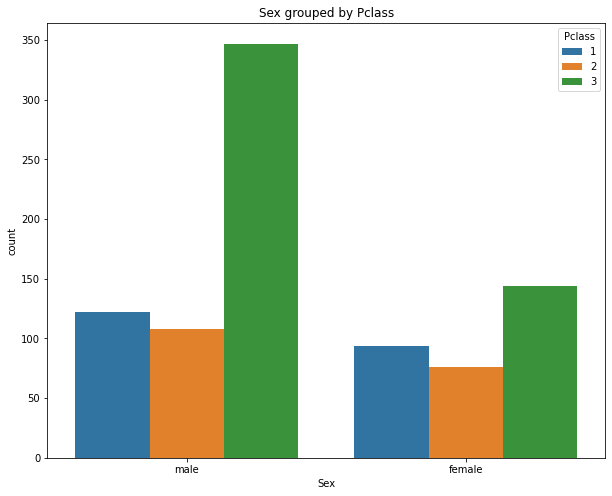

In [144]:
plot_feature_hue_var(df_train, 'Sex', 'Pclass')

Cоздадим новый признак

In [145]:
df_train['SexPerPclass'] = df_train['Sex'] + df_train.astype({'Pclass': 'str'})['Pclass']
df_test['SexPerPclass'] = df_test['Sex'] + df_test.astype({'Pclass': 'str'})['Pclass']
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EmbarkedPerPclass,EmbarkedPerSex,SexPerPclass
0,1,0,3,male,22.0,1,0,7.2500,2,5,5,male3
1,2,1,1,female,38.0,1,0,71.2833,0,0,0,female1
2,3,1,3,female,26.0,0,0,7.9250,2,5,4,female3
3,4,1,1,female,35.0,1,0,53.1000,2,0,4,female1
4,5,0,3,male,35.0,0,0,8.0500,2,5,5,male3


Проанализируем новый признак в разрезе целевой переменной

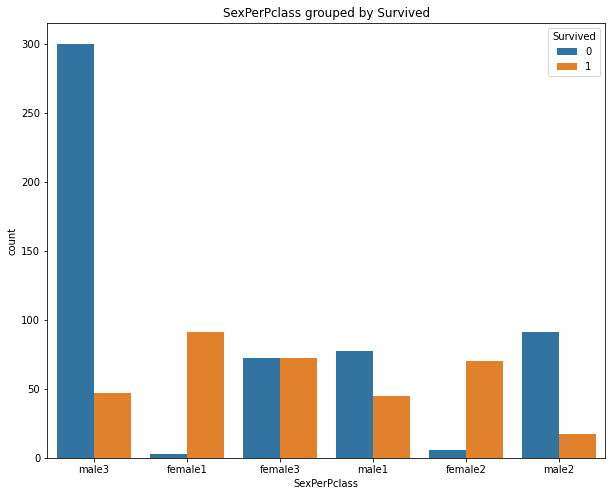

In [146]:
plot_feature_hue_var(df_train, 'SexPerPclass', TARGET_VAR)

Очевидно, что большинство женщин из 1 и 2 классов выжили. Проверим гипотезу о том согласованы ли частоты данных признаков.

**Гипотеза**
1. Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
2. Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
3. Критерий: Хи-квадрат Пирсона
4. Уровень значимости  𝛼 : 0.05
5. Критическая область: двухсторонняя

In [147]:
my_chi2_contingency(data = df_train, feature='SexPerPclass', feature_var1='female1', 
                    feature_var2='female2', target_var='Survived', id_var='PassengerId')

p-value = 0.15098971033058411

Значение p-value для признаков female1 и female2 получилось больше 0,05, соответственно нет повода для отвержения нулевой гипотезы, а значит признаки одинаково влияют на целевую переменную. Объединим их в один признак.


In [148]:
df_train.replace(to_replace = 'female1', value = 'female1_2', inplace = True)
df_train.replace(to_replace = 'female2', value = 'female1_2', inplace = True)

df_test.replace(to_replace = 'female1', value = 'female1_2', inplace = True)
df_test.replace(to_replace = 'female2', value = 'female1_2', inplace = True)

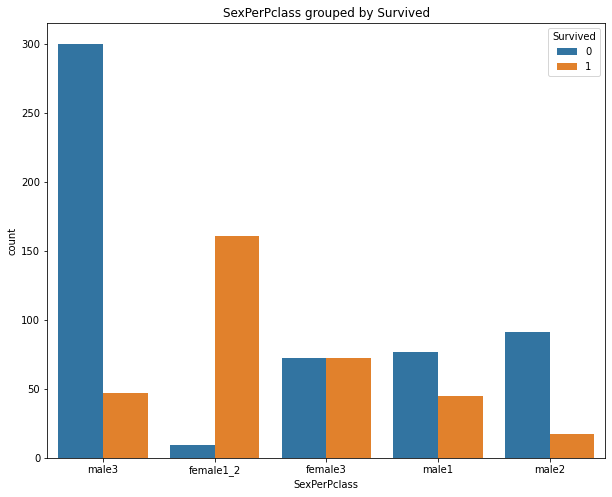

In [149]:
plot_feature_hue_var(df_train, 'SexPerPclass', TARGET_VAR)

Проверим гипотезу о том согласованы ли частоты признаков male1 и male2.

**Гипотеза**

1. Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
2. Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
3. Критерий: Хи-квадрат Пирсона
4. Уровень значимости 𝛼 : 0.05
5. Критическая область: двухсторонняя

In [150]:
my_chi2_contingency(data = df_train, feature='SexPerPclass', feature_var1='male1', 
                    feature_var2='male2', target_var='Survived', id_var='PassengerId')

p-value = 0.010067695902422315

Значение p-value для признаков male1 и male2 получилось меньше 0,05, соответственно принимаем альтернативную гипотезу.


Преобразуем категориальный признак Sex в количественный, где male=0, female = 1

In [151]:
#создадим временный словарь
foo_dict={
    'male': 0,
    'female': 1,
}

#преобразование переменной
df_train['Sex'] = df_train['Sex'].replace(foo_dict)
df_test['Sex'] = df_test['Sex'].replace(foo_dict)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Sex                891 non-null    int64  
 4   Age                714 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Fare               891 non-null    float64
 8   Embarked           891 non-null    int32  
 9   EmbarkedPerPclass  891 non-null    int32  
 10  EmbarkedPerSex     891 non-null    int32  
 11  SexPerPclass       891 non-null    object 
dtypes: float64(2), int32(3), int64(6), object(1)
memory usage: 73.2+ KB


Для преобразования признаков из категориальных в количественные воспользуемся моделью LabelEncoder библиотеки sklearn

In [152]:
le.fit(df_train.SexPerPclass)
df_train['SexPerPclass'] = le.transform(df_train.SexPerPclass)
df_test['SexPerPclass'] = le.transform(df_test.SexPerPclass)

In [153]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Sex                891 non-null    int64  
 4   Age                714 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Fare               891 non-null    float64
 8   Embarked           891 non-null    int32  
 9   EmbarkedPerPclass  891 non-null    int32  
 10  EmbarkedPerSex     891 non-null    int32  
 11  SexPerPclass       891 non-null    int32  
dtypes: float64(2), int32(4), int64(6)
memory usage: 69.7 KB


## Заполнение пропусков в признаке Age

In [154]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Пропуски заполним медианой

In [155]:
df_train['Age'].fillna(df_train['Age'].median(), inplace = True)
df_test['Age'].fillna(df_test['Age'].median(), inplace = True)

In [156]:
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EmbarkedPerPclass,EmbarkedPerSex,SexPerPclass
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.361582,0.523008,0.381594,32.204208,1.536476,3.062851,3.720539,2.356902
std,257.353842,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,49.693429,0.791503,2.040181,1.702415,1.574554
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,1.000000,3.000000,1.000000
50%,446.000000,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,2.000000,4.000000,4.000000,3.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,5.000000,5.000000,4.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,5.000000,5.000000,4.000000


In [157]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Sex                891 non-null    int64  
 4   Age                891 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Fare               891 non-null    float64
 8   Embarked           891 non-null    int32  
 9   EmbarkedPerPclass  891 non-null    int32  
 10  EmbarkedPerSex     891 non-null    int32  
 11  SexPerPclass       891 non-null    int32  
dtypes: float64(2), int32(4), int64(6)
memory usage: 69.7 KB


In [158]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        418 non-null    int64  
 1   Pclass             418 non-null    int64  
 2   Sex                418 non-null    int64  
 3   Age                418 non-null    float64
 4   SibSp              418 non-null    int64  
 5   Parch              418 non-null    int64  
 6   Fare               417 non-null    float64
 7   Embarked           418 non-null    int32  
 8   EmbarkedPerPclass  418 non-null    int32  
 9   EmbarkedPerSex     418 non-null    int32  
 10  SexPerPclass       418 non-null    int32  
dtypes: float64(2), int32(4), int64(5)
memory usage: 29.5 KB


## Заполнение пропусков Fare в тестовом датасете

In [159]:
df_test['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [160]:
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

In [161]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        418 non-null    int64  
 1   Pclass             418 non-null    int64  
 2   Sex                418 non-null    int64  
 3   Age                418 non-null    float64
 4   SibSp              418 non-null    int64  
 5   Parch              418 non-null    int64  
 6   Fare               418 non-null    float64
 7   Embarked           418 non-null    int32  
 8   EmbarkedPerPclass  418 non-null    int32  
 9   EmbarkedPerSex     418 non-null    int32  
 10  SexPerPclass       418 non-null    int32  
dtypes: float64(2), int32(4), int64(5)
memory usage: 29.5 KB


## Корреляция целевой переменной с используемыми признаками

In [162]:
USED_FEATURE_NAMES = df_train.columns.drop([TARGET_VAR, 'PassengerId']).tolist()

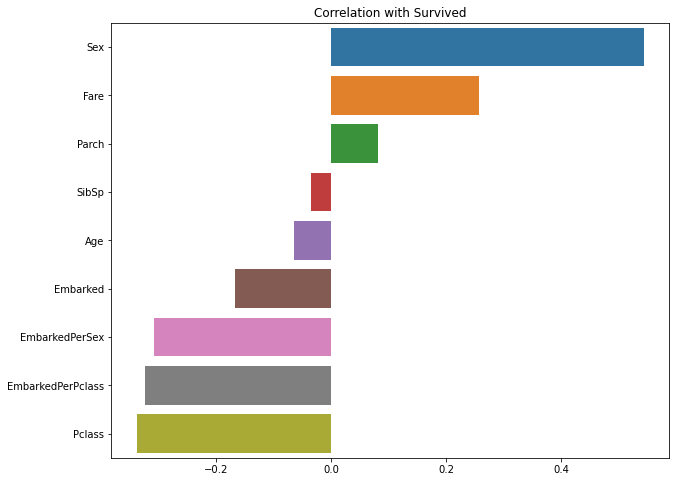

In [163]:
correliation_features(df_train, USED_FEATURE_NAMES, TARGET_VAR)

### Создание новых признаков

**SexPerAge**

In [164]:
df_train['SexPerAge'] = df_train['Sex'] / df_train['Age']
df_test['SexPerAge'] = df_test['Sex'] / df_test['Age']

In [165]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'EmbarkedPerPclass', 'EmbarkedPerSex',
       'SexPerPclass', 'SexPerAge'],
      dtype='object')

In [166]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_VAR, 'PassengerId']).tolist()

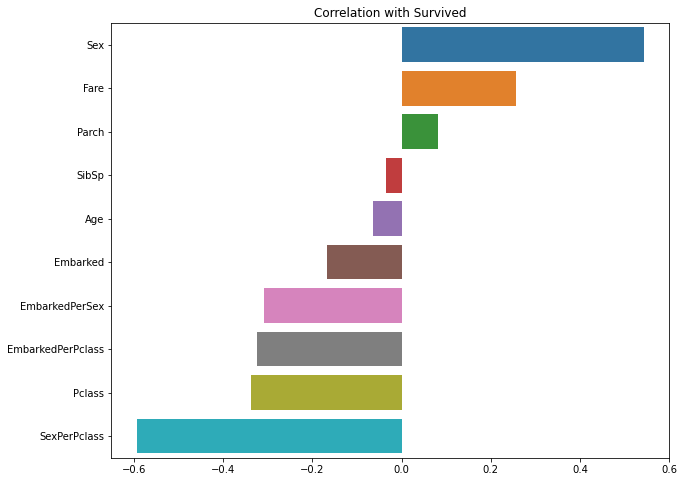

In [167]:
correliation_features(df_train, NEW_FEATURE_NAMES, TARGET_VAR)

# Обучение моделей

## Нормализация признаков

In [168]:
scaler1 = StandardScaler()

df_scal = df_train.copy()
df_scal[NEW_FEATURE_NAMES] = scaler1.fit_transform(df_scal[NEW_FEATURE_NAMES])

df_test_scal = df_test.copy()
df_test_scal[NEW_FEATURE_NAMES] = scaler1.transform(df_test_scal[NEW_FEATURE_NAMES])

## Разбиение на train и test

In [169]:
X = df_scal[NEW_FEATURE_NAMES]
y = df_scal[TARGET_VAR]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)


## Сохранение выборок

In [171]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [172]:
train.to_csv('../titanic/datasets/2021-11-18_train.csv', index = False, encoding='utf-8')
test.to_csv('../titanic/datasets/2021-11-18_test.csv', index = False, encoding='utf-8')

## Построение базовых моделей

In [173]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.800561797752809
Метрика accuracy на тестовом датасете: 0.8100558659217877


In [174]:
model_svc = SVC(random_state=42)
model_svc.fit(X_train, y_train)

y_train_pred = model_svc.predict(X_train)
y_test_pred = model_svc.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.8441011235955056
Метрика accuracy на тестовом датасете: 0.8212290502793296


In [175]:
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train, y_train)

y_train_pred = model_rfc.predict(X_train)
y_test_pred = model_rfc.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.9789325842696629
Метрика accuracy на тестовом датасете: 0.8212290502793296


In [176]:
model_gbc = GradientBoostingClassifier(random_state=42)
model_gbc.fit(X_train, y_train)

y_train_pred = model_gbc.predict(X_train)
y_test_pred = model_gbc.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.8918539325842697
Метрика accuracy на тестовом датасете: 0.8212290502793296


In [177]:
model_knc = KNeighborsClassifier()
model_knc.fit(X_train, y_train)

y_train_pred = model_knc.predict(X_train)
y_test_pred = model_knc.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.8651685393258427
Метрика accuracy на тестовом датасете: 0.7988826815642458


In [178]:
model_lgbm = lgbm.LGBMClassifier(random_state=42)

model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.9396067415730337
Метрика accuracy на тестовом датасете: 0.8212290502793296


### Подбор гиперпараметров

In [179]:
params = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10],    
    'n_estimators': [50, 100, 200, 400, 600, 800,],
    'max_depth': [3, 5, 7, 9],
    'max_features': [3, 4, 5, 6, 7]
}

In [180]:
cv_model_gbc = RandomizedSearchCV(model_gbc, params, cv = 4, scoring='accuracy')

In [183]:
%%time
cv_model_gbc.fit(X_train, y_train)

cv_model_gbc.best_params_

Wall time: 23.4 s


{'n_estimators': 100, 'max_features': 6, 'max_depth': 3, 'learning_rate': 0.01}

In [184]:
y_train_pred = cv_model_gbc.predict(X_train)
y_test_pred = cv_model_gbc.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.8384831460674157
Метрика accuracy на тестовом датасете: 0.8044692737430168


## Итоговая модель

In [185]:
final_model_gbc = GradientBoostingClassifier(random_state=42, learning_rate=0.01, n_estimators=100,
                                             max_depth=3, max_features=6)

In [186]:
final_model_gbc.fit(X_train, y_train)
y_train_pred = final_model_gbc.predict(X_train)
y_test_pred = final_model_gbc.predict(X_test)

my_accuracy_score(y_train, y_train_pred, y_test, y_test_pred)

Метрика accuracy на тренировочном датасете: 0.8384831460674157
Метрика accuracy на тестовом датасете: 0.8044692737430168


In [187]:
test_preds = final_model_gbc.predict(df_test_scal[NEW_FEATURE_NAMES])

In [188]:
preds = pd.DataFrame()
preds['PassengerId'] = df_test['PassengerId']
preds['Survived'] = test_preds
preds.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [189]:
preds.to_csv('2021-11-18 preds_gbc.csv', index = False)